In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import matplotlib.pyplot as plt
import os

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

0it [00:00, ?it/s]

In [14]:
COLUMN_OF_INTEREST =['QUOTE_UNIXTIME','QUOTE_DATE','EXPIRE_DATE','EXPIRE_UNIX',
                            'DTE','C_BID','C_ASK', 'P_BID','P_ASK',
                             'UNDERLYING_LAST','STRIKE','STRIKE_DISTANCE']

In [15]:
df_options_spy = pd.read_csv('data/2020-2022_SPY_30days.csv')

# convert QUOTE_DATE and EXPIRE_DATE to datetime
df_options_spy['QUOTE_DATE'] = pd.to_datetime(df_options_spy['QUOTE_DATE'])
df_options_spy['EXPIRE_DATE'] = pd.to_datetime(df_options_spy['EXPIRE_DATE'])

# drop QUOTE_UNIXTIME and EXPIRE_UNIX
df_options_spy = df_options_spy.drop(['QUOTE_UNIXTIME', 'EXPIRE_UNIX'], axis=1)

# set "" to NaN
df_options_spy = df_options_spy.replace(r'^\s*$', np.nan, regex=True)

# drop rows with NaN
df_options_spy = df_options_spy.dropna()

# convert C_BID, C_ASK, P_BID, P_ASK to float
df_options_spy['C_BID'] = df_options_spy['C_BID'].astype(float)
df_options_spy['C_ASK'] = df_options_spy['C_ASK'].astype(float)
df_options_spy['P_BID'] = df_options_spy['P_BID'].astype(float)
df_options_spy['P_ASK'] = df_options_spy['P_ASK'].astype(float)

In [16]:
df_options_spy.dtypes

QUOTE_DATE         datetime64[ns]
EXPIRE_DATE        datetime64[ns]
DTE                       float64
C_BID                     float64
C_ASK                     float64
P_BID                     float64
P_ASK                     float64
UNDERLYING_LAST           float64
STRIKE                    float64
STRIKE_DISTANCE           float64
dtype: object

In [17]:
df_options_spy.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE
0,2020-01-03,2020-01-03,0.0,62.43,63.04,0.0,0.01,322.43,260.0,62.4
1,2020-01-03,2020-01-03,0.0,57.43,58.07,0.0,0.01,322.43,265.0,57.4
2,2020-01-03,2020-01-03,0.0,52.34,53.06,0.0,0.01,322.43,270.0,52.4
3,2020-01-03,2020-01-03,0.0,49.91,50.54,0.0,0.01,322.43,272.5,49.9
4,2020-01-03,2020-01-03,0.0,47.35,48.04,0.0,0.00,322.43,275.0,47.4


In [18]:
# Calculate the rolling volatility of the underlying price
import yfinance as yf
from pypfopt.risk_models import CovarianceShrinkage

TICKER = ['SPY']

start_date = '2017-01-01' # you need to have at least 2 years of data before the start date as we are calculating the rolling volatility of 2 years
end_date = '2023-01-01' # end date is exclusive, the data will be downloaded until 2022-12-31

df = yf.download(TICKER, start=start_date, end=end_date)

# calculate the rolling volatility of 2 years (252 trading days per year)
# rolling_period = 252*2
rolling_period = int(252)
# dt = 1/252

# VOLATILITY METHOD 1: calculate the volatility using log return and take the standard deviation as is
# df['log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
# df['volatility'] = df['log_return'].rolling(rolling_period).std() * np.sqrt(252)

# VOLATILITY METHOD 2: calculate the volatility using log return and CovarianceShrinkage
df_spy = df['Adj Close']
df_spy.index.name = None
df['volatility'] = np.nan

#Apply rolling period of 2 years to CovarianceShrinkage
for i in range(rolling_period, len(df_spy)):
    cov_matrix = CovarianceShrinkage(df_spy.iloc[i-rolling_period:i], log_returns=True).ledoit_wolf() 

    #calculate the volatility. cov_matrix is annualized, so no need to multiply by sqrt(252)
    df['volatility'].iloc[i] = np.sqrt(cov_matrix.iloc[0,0])
    
# we only need the data from 2020 to 2022
df = df.loc['2020-01-01':'2022-12-31']

[*********************100%***********************]  1 of 1 completed


In [19]:
# risk free rate for 2020 to 2022 is around 2.5% per annum
risk_free_rate = 0.025

# dividend yield is rate is roughly 1.5% per annum for SPY
dividend_yield = 0.015

In [20]:
def binomial_model(S0, K, T, r, sigma, N, 
                   option='call', div=0, 
                   european=True, method='crr'):
    ''' Binomial model for option pricing.
    Parameters
    ==========
    S0 : float
        initial stock/index level
    K : float
        strike price
    T : float
        maturity (in year fractions)
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term 
    N : int
        number of time intervals
    option : string
        type of the option to be valued ('call' or 'put')
    div : float
        annualized continuous dividend yield
    european : boolean
        True for European option valuation
        False for American option valuation
    method : string
        'crr' for Cox, Ross and Rubinstein
        'jr' for Jarrow and Rudd/equal probabilities 
    Returns
    =======
    value : float
        present value of the European option
    '''
    dt = T / N
    
    # calculate the risk-neutral probability
    if method == 'crr':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - div) * dt) - d) / (u - d)
    elif method == 'jr':
        u = np.exp((r-div-0.5*sigma**2)*dt+sigma*np.sqrt(dt))
        d = np.exp((r-div-0.5*sigma**2)*dt-sigma*np.sqrt(dt))
        p = 0.5
    else:
        raise ValueError('method not recognized')

    q = 1 - p

    # initialize terminal stock prices at maturity
    stock_prices = np.zeros((N + 1, N + 1))
    stock_prices[0, 0] = S0
    for i in range(1, N + 1):
        stock_prices[0, i] = stock_prices[0, i - 1] * u
        for j in range(1, i + 1):
            stock_prices[j, i] = stock_prices[j - 1, i - 1] * d

    # calculate option values at maturity
    option_values = np.zeros((N + 1, N + 1))
    if option == 'call':
        option_values[:, N] = np.maximum(stock_prices[:, N] - K, 0)
    else:
        option_values[:, N] = np.maximum(K - stock_prices[:, N], 0)

    # backward induction
    if european:
        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                option_values[j, i] = np.exp(-r * dt) * (p * option_values[j, i + 1] + q * option_values[j + 1, i + 1])
    else:
        if option == 'call':
            for i in range(N - 1, -1, -1):
                for j in range(i + 1):
                    option_values[j, i] = np.exp(-r * dt) * (p * option_values[j, i + 1] + q * option_values[j + 1, i + 1])
                    option_values[j, i] = np.maximum(option_values[j, i], stock_prices[j, i] - K)
        else:
            for i in range(N - 1, -1, -1):
                for j in range(i + 1):
                    option_values[j, i] = np.exp(-r * dt) * (p * option_values[j, i + 1] + q * option_values[j + 1, i + 1])
                    option_values[j, i] = np.maximum(option_values[j, i], K - stock_prices[j, i])
    
    return option_values[0, 0]

In [21]:
S0 = 3246.23
K = 2000
T = 21/252
r = 0.025
div = 0.015
sigma = 0.1498878078948466
N = 21
print(binomial_model(S0, K, T, r, sigma, N, option='call', div=div, european=True, method='crr'))
print(binomial_model(S0, K, T, r, sigma, N, option='call', div=div, european=True, method='jr'))

1246.3370769621977
1246.3370318672155


In [22]:
# merge the dataframes of df_options and df where df_options QUOTE_DATE is same as df index
df_model_input = df_options_spy.merge(df['volatility'], left_on='QUOTE_DATE', right_on=df.index)
df_model_input = df_model_input[df_model_input['DTE']==30]

In [23]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility
178,2020-01-06,2020-02-05,30.0,34.14,34.43,0.30,0.33,323.68,290.0,33.7,0.119088
179,2020-01-06,2020-02-05,30.0,29.38,29.67,0.42,0.45,323.68,295.0,28.7,0.119088
180,2020-01-06,2020-02-05,30.0,24.57,24.84,0.64,0.64,323.68,300.0,23.7,0.119088
181,2020-01-06,2020-02-05,30.0,19.85,20.12,0.93,0.93,323.68,305.0,18.7,0.119088
182,2020-01-06,2020-02-05,30.0,18.97,19.21,1.00,1.02,323.68,306.0,17.7,0.119088


In [24]:
# backtest the binomial model
# track the progress of the backtest
N_PLUS=0
df_model_input['binomial_model_crr_call'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='call', div=dividend_yield, 
                             european=False, method='crr'), axis=1)

  0%|          | 0/29298 [00:00<?, ?it/s]

In [25]:
# backtest the binomial model
# track the progress of the backtest

N_PLUS=0
df_model_input['binomial_model_crr_put'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='put', div=dividend_yield, 
                             european=False, method='crr'), axis=1)

  0%|          | 0/29298 [00:00<?, ?it/s]

In [26]:
df_model_input['binomial_model_jr_call'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='call', div=dividend_yield, 
                             european=False, method='jr'), axis=1)


  0%|          | 0/29298 [00:00<?, ?it/s]

In [27]:
df_model_input['binomial_model_jr_put'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='put', div=dividend_yield, 
                             european=False, method='jr'), axis=1)


  0%|          | 0/29298 [00:00<?, ?it/s]

In [28]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility,binomial_model_crr_call,binomial_model_crr_put,binomial_model_jr_call,binomial_model_jr_put
178,2020-01-06,2020-02-05,30.0,34.14,34.43,0.30,0.33,323.68,290.0,33.7,0.119088,33.877621,0.001157,33.877600,0.001138
179,2020-01-06,2020-02-05,30.0,29.38,29.67,0.42,0.45,323.68,295.0,28.7,0.119088,28.895160,0.008444,28.895169,0.008455
180,2020-01-06,2020-02-05,30.0,24.57,24.84,0.64,0.64,323.68,300.0,23.7,0.119088,23.936181,0.039249,23.936405,0.039475
181,2020-01-06,2020-02-05,30.0,19.85,20.12,0.93,0.93,323.68,305.0,18.7,0.119088,19.071045,0.164349,19.070298,0.163612
182,2020-01-06,2020-02-05,30.0,18.97,19.21,1.00,1.02,323.68,306.0,17.7,0.119088,18.121655,0.212914,18.121618,0.212887


In [29]:
df_eval = df_model_input[['QUOTE_DATE', 
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_eval['C_PRICE'] = (df_eval['C_BID'] + df_eval['C_ASK'])/2
df_eval['P_PRICE'] = (df_eval['P_BID'] + df_eval['P_ASK'])/2
df_eval = df_eval.set_index('QUOTE_DATE')
df_eval.head()

,binomial_model_crr_call,binomial_model_jr_call,C_BID,C_ASK,binomial_model_crr_put,binomial_model_jr_put,P_BID,P_ASK,DTE,STRIKE,C_PRICE,P_PRICE
QUOTE_DATE,,,,,,,,,,,,
2020-01-06,33.877621,33.877600,34.14,34.43,0.001157,0.001138,0.30,0.33,30.0,290.0,34.285,0.315
2020-01-06,28.895160,28.895169,29.38,29.67,0.008444,0.008455,0.42,0.45,30.0,295.0,29.525,0.435
2020-01-06,23.936181,23.936405,24.57,24.84,0.039249,0.039475,0.64,0.64,30.0,300.0,24.705,0.640
2020-01-06,19.071045,19.070298,19.85,20.12,0.164349,0.163612,0.93,0.93,30.0,305.0,19.985,0.930
2020-01-06,18.121655,18.121618,18.97,19.21,0.212914,0.212887,1.00,1.02,30.0,306.0,19.090,1.010


In [30]:
#calculate absolute error of binomial model
df_eval['binomial_model_crr_call_error'] = df_eval['binomial_model_crr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_jr_call_error'] = df_eval['binomial_model_jr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_crr_put_error'] = df_eval['binomial_model_crr_put'] - df_eval['P_PRICE']
df_eval['binomial_model_jr_put_error'] = df_eval['binomial_model_jr_put'] - df_eval['P_PRICE']

#calculate root mean squared error of binomial model
print('Root Mean Squared Error of CRR Call model:',np.sqrt(np.mean(df_eval['binomial_model_crr_call_error']**2)))
print('Root Mean Squared Error of JR Call model:',np.sqrt(np.mean(df_eval['binomial_model_jr_call_error']**2)))
print('Root Mean Squared Error of CRR Put model:',np.sqrt(np.mean(df_eval['binomial_model_crr_put_error']**2)))
print('Root Mean Squared Error of JR Put model:',np.sqrt(np.mean(df_eval['binomial_model_jr_put_error']**2)))

#calculate mean absolute error of binomial model
print('Mean Absolute Error of CRR Call model:',np.mean(np.abs(df_eval['binomial_model_crr_call_error'])))
print('Mean Absolute Error of JR Call model:',np.mean(np.abs(df_eval['binomial_model_jr_call_error'])))
print('Mean Absolute Error of CRR Put model:',np.mean(np.abs(df_eval['binomial_model_crr_put_error'])))
print('Mean Absolute Error of JR Put model:',np.mean(np.abs(df_eval['binomial_model_jr_put_error'])))

#calculate mean absolute percentage error of binomial model
print('Percentage Mean Absolute Error of CRR Call model:', np.mean(np.abs(df_eval['binomial_model_crr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Call model:', np.mean(np.abs(df_eval['binomial_model_jr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of CRR Put model:', np.mean(np.abs(df_eval['binomial_model_crr_put_error']/df_eval['P_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Put model:', np.mean(np.abs(df_eval['binomial_model_jr_put_error']/df_eval['P_PRICE']))*100,'%')


Root Mean Squared Error of CRR Call model: 2.2014100611172305
Root Mean Squared Error of JR Call model: 2.20106085892575
Root Mean Squared Error of CRR Put model: 2.22110563336325
Root Mean Squared Error of JR Put model: 2.2208531358673067
Mean Absolute Error of CRR Call model: 1.3305738051701594
Mean Absolute Error of JR Call model: 1.3303493736565066
Mean Absolute Error of CRR Put model: 1.398773889537427
Mean Absolute Error of JR Put model: 1.3986057640544654
Percentage Mean Absolute Error of CRR Call model: inf %
Percentage Mean Absolute Error of JR Call model: inf %
Percentage Mean Absolute Error of CRR Put model: 46.93462325866038 %
Percentage Mean Absolute Error of JR Put model: 46.93024163426174 %


In [31]:
df_input = df_model_input[['QUOTE_DATE', 'EXPIRE_DATE',
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_input['C_PRICE'] = (df_input['C_BID'] + df_input['C_ASK'])/2
df_input['P_PRICE'] = (df_input['P_BID'] + df_input['P_ASK'])/2
df_input.drop(['C_BID','C_ASK', 'P_BID','P_ASK',], axis=1, inplace=True)
df_input = df_input.set_index('QUOTE_DATE')
df_input.tail()

,EXPIRE_DATE,binomial_model_crr_call,binomial_model_jr_call,binomial_model_crr_put,binomial_model_jr_put,DTE,STRIKE,C_PRICE,P_PRICE
QUOTE_DATE,,,,,,,,,
2022-12-28,2023-01-27,0.001115,0.001094,103.29,103.29,30.0,480.0,0.015,103.205
2022-12-28,2023-01-27,0.000386,0.000400,108.29,108.29,30.0,485.0,0.015,108.205
2022-12-28,2023-01-27,0.000250,0.000252,113.29,113.29,30.0,490.0,0.005,113.205
2022-12-28,2023-01-27,0.000115,0.000104,118.29,118.29,30.0,495.0,0.005,118.205
2022-12-28,2023-01-27,0.000043,0.000045,123.29,123.29,30.0,500.0,0.005,123.205


In [32]:
df_price = df_model_input[['QUOTE_DATE', 'UNDERLYING_LAST']]
df_price = df_price.drop_duplicates()
df_price = df_price.set_index('QUOTE_DATE')

# remove rows where expiry date is greater max quote date
df_input = df_input[df_input['EXPIRE_DATE'] <= df_input.index.max()]
df_input['UNDERLYING_PRICE_EXPIRE'] = df_input['EXPIRE_DATE'].progress_apply(
    lambda x: df_price.loc[x]['UNDERLYING_LAST'] if x in df_price.index 
    else df_price.loc[df_price.index[df_price.index.get_loc(x, method='bfill')]]['UNDERLYING_LAST'])

  0%|          | 0/28486 [00:00<?, ?it/s]

In [33]:
df_binomial_model_crr = df_input[['binomial_model_crr_call', 'binomial_model_crr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_crr = df_binomial_model_crr.rename(columns={'binomial_model_crr_call':'call', 'binomial_model_crr_put':'put'})

df_binomial_model_jr = df_input[['binomial_model_jr_call', 'binomial_model_jr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_jr = df_binomial_model_jr.rename(columns={'binomial_model_jr_call':'call', 'binomial_model_jr_put':'put'})

In [34]:
df_binomial_model_crr['long_call'] = np.where(df_binomial_model_crr['call'] > df_binomial_model_crr['C_PRICE'], 1, -1)
df_binomial_model_crr['long_put'] = np.where(df_binomial_model_crr['put'] > df_binomial_model_crr['P_PRICE'], 1, -1)
df_binomial_model_crr['PROFIT_LOSS_ON_PURCHASE'] = -1*(df_binomial_model_crr['long_call']*df_binomial_model_crr['C_PRICE'] + df_binomial_model_crr['long_put']*df_binomial_model_crr['P_PRICE'])

df_binomial_model_jr['long_call'] = np.where(df_binomial_model_jr['call'] > df_binomial_model_jr['C_PRICE'], 1, -1)
df_binomial_model_jr['long_put'] = np.where(df_binomial_model_jr['put'] > df_binomial_model_jr['P_PRICE'], 1, -1)
df_binomial_model_jr['PROFIT_LOSS_ON_PURCHASE'] = -1*(df_binomial_model_jr['long_call']*df_binomial_model_jr['C_PRICE'] + df_binomial_model_jr['long_put']*df_binomial_model_jr['P_PRICE'])

In [35]:
df_binomial_model_crr['PROFIT_LOSS_ON_SALE'] = (df_binomial_model_crr['long_call']*np.maximum(df_binomial_model_crr['UNDERLYING_PRICE_EXPIRE'] - df_binomial_model_crr['STRIKE'], 0) + 
                                        df_binomial_model_crr['long_put']*np.maximum(df_binomial_model_crr['STRIKE'] - df_binomial_model_crr['UNDERLYING_PRICE_EXPIRE'], 0))
df_binomial_model_crr['PROFIT_LOSS'] = df_binomial_model_crr['PROFIT_LOSS_ON_SALE'] + df_binomial_model_crr['PROFIT_LOSS_ON_PURCHASE']

df_binomial_model_jr['PROFIT_LOSS_ON_SALE'] = (df_binomial_model_jr['long_call']*np.maximum(df_binomial_model_jr['UNDERLYING_PRICE_EXPIRE'] - df_binomial_model_jr['STRIKE'], 0) +
                                        df_binomial_model_jr['long_put']*np.maximum(df_binomial_model_jr['STRIKE'] - df_binomial_model_jr['UNDERLYING_PRICE_EXPIRE'], 0))
df_binomial_model_jr['PROFIT_LOSS'] = df_binomial_model_jr['PROFIT_LOSS_ON_SALE'] + df_binomial_model_jr['PROFIT_LOSS_ON_PURCHASE']

In [36]:
df_binomial_model_crr.tail()

,call,put,DTE,STRIKE,C_PRICE,P_PRICE,EXPIRE_DATE,UNDERLYING_PRICE_EXPIRE,long_call,long_put,PROFIT_LOSS_ON_PURCHASE,PROFIT_LOSS_ON_SALE,PROFIT_LOSS
QUOTE_DATE,,,,,,,,,,,,,
2022-11-23,0.042306,77.58,30.0,480.0,0.015,78.505,2022-12-23,376.71,1,-1,78.490,-103.29,-24.800
2022-11-23,0.028943,82.58,30.0,485.0,0.015,83.165,2022-12-23,376.71,1,-1,83.150,-108.29,-25.140
2022-11-23,0.016787,87.58,30.0,490.0,0.015,88.150,2022-12-23,376.71,1,-1,88.135,-113.29,-25.155
2022-11-23,0.009025,92.58,30.0,495.0,0.005,93.135,2022-12-23,376.71,1,-1,93.130,-118.29,-25.160
2022-11-23,0.005720,97.58,30.0,500.0,0.005,98.420,2022-12-23,376.71,1,-1,98.415,-123.29,-24.875


Mean Profit/Loss of CRR model: -0.5041216738046767
Mean Profit/Loss of JR model: -0.498345152004494
Volatility of CRR model: 19.96235796603036
Volatility of JR model: 19.966618662369537
Total Profit/Loss of CRR model: -14360.41000000002
Total Profit/Loss of JR model: -14195.860000000015
Plotting daily Profit/Loss of CRR model


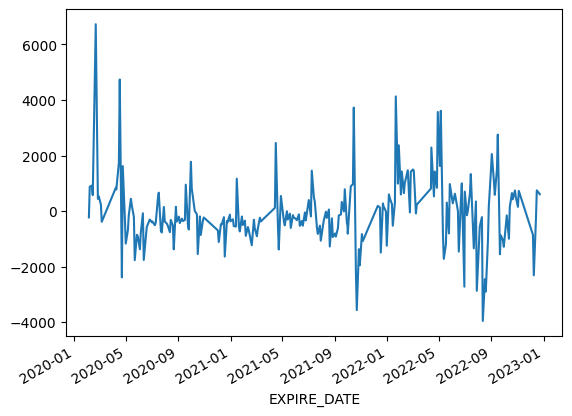

Plotting daily Profit/Loss of JR model


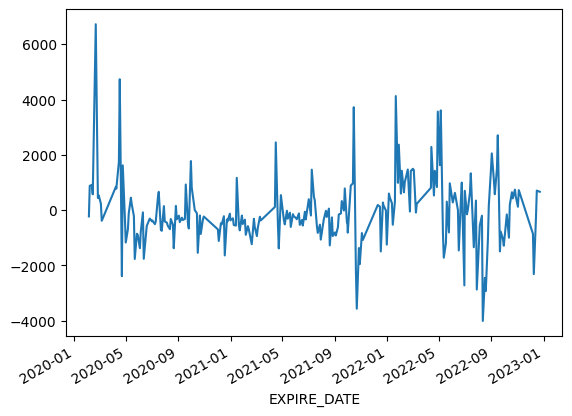

Plotting Cumulative Profit/Loss of CRR model


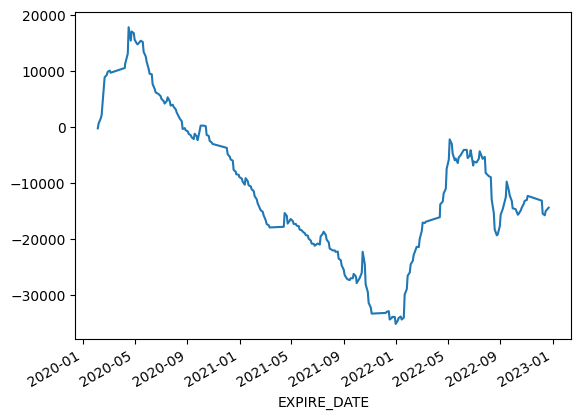

Plotting Cumulative Profit/Loss of JR model


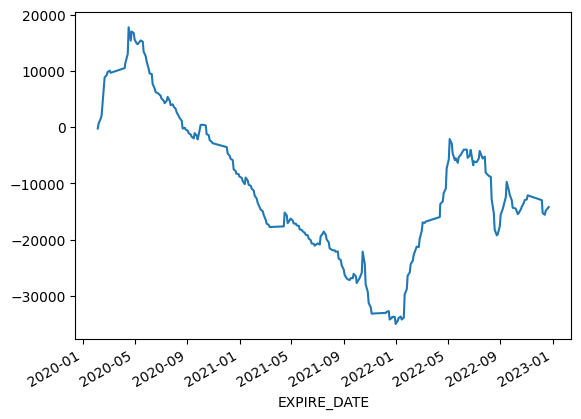

In [37]:
print('Mean Profit/Loss of CRR model:',np.mean(df_binomial_model_crr['PROFIT_LOSS']))
print('Mean Profit/Loss of JR model:',np.mean(df_binomial_model_jr['PROFIT_LOSS']))
print('Volatility of CRR model:',np.std(df_binomial_model_crr['PROFIT_LOSS']))
print('Volatility of JR model:',np.std(df_binomial_model_jr['PROFIT_LOSS']))
print('Total Profit/Loss of CRR model:',np.sum(df_binomial_model_crr['PROFIT_LOSS']))
print('Total Profit/Loss of JR model:',np.sum(df_binomial_model_jr['PROFIT_LOSS']))

print('Plotting daily Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting daily Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting Cumulative Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()

print('Plotting Cumulative Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()